In [198]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle

In [203]:
T = 60
Rx = 100.
Ry = 1000.
batch_size = 1_000

kappa = [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
sigma = [1, 0.3, 0.5, 1.5, 1.75, 2, 2.25]
p = [0.35, 0.3, 0.34, 0.33, 0.32, 0.31, 0.3]
phi = np.repeat(0.03, 7)

In [ ]:
''' Initial reserves '''
Rx0   = np.repeat(Rx, len(kappa))
Ry0   = np.repeat(Ry, len(kappa))

pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

xs_0 = np.repeat(1., len(kappa))
l = pools.swap_and_mint(xs_0)
end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 304.01it/s]


In [ ]:
x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
log_ret = np.log(x_T)
Y = pd.DataFrame(log_ret)
Y

,0,1,2,3,4,5,6
0,0.119733,0.085552,0.153972,-0.044518,1.991362,-0.095006,0.032564
1,-0.018704,-0.093006,0.045084,-0.295211,-0.144976,-0.125766,-0.184205
2,0.171639,0.108575,-0.112979,0.097815,0.002596,0.059422,0.035852
3,0.112579,0.088779,-0.018894,-0.018868,0.249881,0.270709,0.017335
4,0.163196,0.229911,0.277760,0.091112,0.176856,0.078718,0.067310
...,...,...,...,...,...,...,...
995,0.140194,0.200951,0.037311,0.067753,0.274753,0.162235,0.058299
996,0.085750,0.080658,0.346661,0.268842,0.079447,0.160434,0.004494
997,-0.048566,0.093751,0.072652,0.150976,0.166943,0.176527,0.006439
998,0.106213,0.092526,0.013257,0.020546,0.191638,0.171798,0.022248


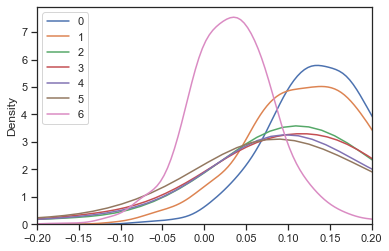

In [ ]:
for i in range(log_ret.shape[1]):
    sns.kdeplot(log_ret[:, i], label=i)
    
plt.xlim((-0.2, 0.2))
plt.legend()

# Portfolio optimization

In [209]:
import riskfolio as rp
import pandas as pd

In [212]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,0,1,2,3,4,5,6
weights,0.664348,0.247657,0.025793,0.00741,0.053364,0.001429,7.830477e-14


<AxesSubplot:ylabel='Density'>

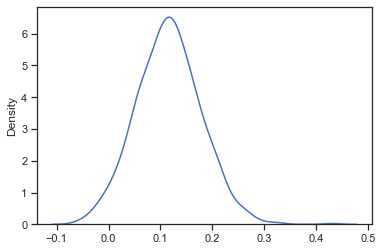

In [173]:
portfolio_returns = log_ret @ w
sns.kdeplot(portfolio_returns.to_numpy().T[0])

# Optimization by hand

1. Adjust code from `riskfolio/src/Portfolio.py`, and incorporate our constraints P(ret >= 0.5) >= 0.7
2. Check if this constraint can be accommodated by riskfolio library

In [ ]:
# pseudocode:
# reference file: riskfolio/src/Portfolio.py

import cvxpy as cp
import numpy as np

SOLVERS = ["ECOS", "SCS", "OSQP", "CVXOPT"]

returns = log_ret
alpha = 0.05

n_returns, n_assets = returns.shape

weights = cp.Variable((n_assets, 1))
var = cp.Variable((1, 1))
Z1 = cp.Variable((n_returns, 1))

X = returns @ weights
cvar = var + 1 / (alpha * n_returns) * cp.sum(Z1)

constraints = [Z1 * 1000 >= 0, Z1 * 1000 >= -X * 1000 - var * 1000]
objective = cp.Minimize(cvar * 1000)

# naive idea:
# constraints += [np.mean(returns @ weights >= 0.05)[0] - 0.7 >= 0]

results = []

prob = cp.Problem(objective, constraints)
for solver in SOLVERS:
    prob.solve(solver=solver)
    results += [np.array(weights.value)]